# View  Spectraction Results in OGA to view gain variation

 work with Weakly_2023_11
- use jupyter kernel LSST
- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab
- creation date : 2023/04/11
- last update : 2023/04/11

- Spectractor https://github.com/lsst/Spectractor/
- Spectractor Version 2.4
- branch lsst-dev
- available in version w_2023_11 by default


In [1]:
! eups list -s | grep LOCAL

atmospec              LOCAL:/home/d/dagoret/repos/repos_w_2023_11/atmospec 	setup
eups                  LOCAL:/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-5.1.0/eups 	setup


In [2]:
! eups list -s lsst_distrib

   gdf42428520+c82c1836b5 	current w_2023_11 setup


In [3]:
import h5py

In [4]:
import lsst.daf.butler as dafButler
#import lsst.summit.utils.butlerUtils as butlerUtils

In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
import pandas as pd

import matplotlib.ticker                         # here's where the formatter is
import os
import re
import pandas as pd

plt.rcParams["figure.figsize"] = (4,3)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'
plt.rcParams.update({'figure.max_open_warning': 0})

In [6]:
import pickle

In [7]:
from astropy.time import Time
import astropy.units as u

## Config

In [8]:
FLAG_MOUNT_ERRORS= True
FLAG_SHOW_ORDER1ORDER2 = True # if want to study both orders

### Butler

In [9]:
#repo =  "/sdf/group/rubin/repo/main"
#repo = "/sdf/group/rubin/repo/oga/"
repo = "/repo/embargo/"
butler = dafButler.Butler(repo)
registry = butler.registry

### Date & Filter & Disperser & collection

- make your choice

In [10]:
DateToRuncollection = {
    
    
 # september 2022
 20220912 :  "u/dagoret/BPS_manyspectro_v60", # Missing collection
 20220913 :  "u/dagoret/BPS_manyspectro_v61", # Missing collection
 20220914 :  "u/dagoret/BPS_manyspectro_v62", # Missing collection  
    
 20220927 :  "u/dagoret/BPS_manyspectro_v63", # Mount errors available, mitigé
 20220928 :  "u/dagoret/BPS_manyspectro_v64", # Mount errors available, very nice spectra
 20220929 :  "u/dagoret/BPS_manyspectro_v65", # Mount errors available, very nice spectra
    
    
 # october 2022
 20221012 :  "u/dagoret/BPS_manyspectro_v56", # mount errors , nice, all good
 20221025 :  "u/dagoret/BPS_manyspectro_v57", # mount errors, very very bad spectra, run not selected
 20221026 :  "u/dagoret/BPS_manyspectro_v58", # mount errors,  very nice spectra, all good
 20221027 :  "u/dagoret/BPS_manyspectro_v59", # mount errors,  nice spectra, all good
    
 # november 2022
 20221109 :  "u/dagoret/BPS_manyspectro_v53", # mount errors, nice spectra, few bad labelled as good 
 20221110 :  "u/dagoret/BPS_manyspectro_v54", # mount errors available, many bad rec spectra, few bad labelled as good, versy strange
 20221123 :  "u/dagoret/BPS_manyspectro_v55", # mount errors , nice   
    
 # december 2022   
 20221207 :  "u/dagoret/BPS_manyspectro_v48", # No mount error, nice spectra
 20221208 :  "u/dagoret/BPS_manyspectro_v49", # No mount error, nice spectra, one bad labelled as good
 20221209 :  "u/dagoret/BPS_manyspectro_v50", # No mount error, spectra at distance from optical center, very interesting
 20221210 :  "u/dagoret/BPS_manyspectro_v51", # No mount error, bof
 20221212 :  "u/dagoret/BPS_manyspectro_v52", # No mount error, very bad gains and instability 
    
 #January 2023 
 20230117 :  "u/dagoret/BPS_manyspectro_v79", # no mount errors, some mucol spectra that looks good are rejected on DCCD
 20230118 :  "u/dagoret/BPS_manyspectro_v80", # no mount error, some mucol looking good are rejected, many bad centroid calculation
 20230119 :  "u/dagoret/BPS_manyspectro_v77", # no mount errors, many blurred spectra probably due to strong tracking error
 20230131 :  "u/dagoret/BPS_manyspectro_v78", # missing for moment

 #february 2023
 20230214 :  "u/dagoret/BPS_manyspectro_v42", # no mount errors, nothing special
 20230215 :  "u/dagoret/BPS_manyspectro_v43", # mount errors, OK
 20230216 :  "u/dagoret/BPS_manyspectro_v44", # mount errors, OK, nice spectra 
 20230228 :  "u/dagoret/BPS_manyspectro_v70", # No mount error,OK nice spectra
    
 #march 2023  
 20230301 :  "u/dagoret/BPS_manyspectro_v71", # no mount errors, OK many spectra
 20230302 :  "u/dagoret/BPS_manyspectro_v72", # no mount error, sometime bad subtraction of order2 on HD38666 (mucol) 
 20230315 :  "u/dagoret/BPS_manyspectro_v73", # mount errors
 20230316 :  "u/dagoret/BPS_manyspectro_v74", # mount errors 
    
}

In [11]:
DATE = 20221212
my_collection = DateToRuncollection[DATE]

filterdispersername = "empty~holo4_003"

RUNSELECTION = 20230330
#RUNSELECTION = 20230403

# List of Dataset types avalaible in my collection

## List of dataset types

In [12]:
list(registry.queryDatasetTypes("*spec*"))

[DatasetType('atmospecCentroid', {band, instrument, detector, physical_filter, visit}, StructuredDataDict),
 DatasetType('spectraction', {band, instrument, detector, physical_filter, visit}, Spectraction),
 DatasetType('spectractorImage', {band, instrument, detector, physical_filter, visit}, SpectractorImage),
 DatasetType('spectractorSpectrum', {band, instrument, detector, physical_filter, visit}, SpectractorSpectrum)]

## list of datasets

In [13]:
list(registry.queryDatasets("*spec*", collections=[my_collection]))[:10]

[DatasetRef(DatasetType('atmospecCentroid', {band, instrument, detector, physical_filter, visit}, StructuredDataDict), {instrument: 'LATISS', detector: 0, visit: 2022121200397, ...}, id=7e69a147-62d1-4497-b2a1-be0bd2937b25, run='u/dagoret/BPS_manyspectro_v52/20230313T153822Z'),
 DatasetRef(DatasetType('atmospecCentroid', {band, instrument, detector, physical_filter, visit}, StructuredDataDict), {instrument: 'LATISS', detector: 0, visit: 2022121200419, ...}, id=e70d552c-6bff-4ae5-83f9-b6867a36c0e5, run='u/dagoret/BPS_manyspectro_v52/20230313T153822Z'),
 DatasetRef(DatasetType('atmospecCentroid', {band, instrument, detector, physical_filter, visit}, StructuredDataDict), {instrument: 'LATISS', detector: 0, visit: 2022121200418, ...}, id=a33a3e17-85ea-4927-a84d-503934b00ee2, run='u/dagoret/BPS_manyspectro_v52/20230313T153822Z'),
 DatasetRef(DatasetType('atmospecCentroid', {band, instrument, detector, physical_filter, visit}, StructuredDataDict), {instrument: 'LATISS', detector: 0, visit: 2

### Spectractor

In [14]:
configmode = "PSF2DFFM_REBIN2"
#configmode = "PSF2DFFM_REBIN1"
#ext="_b"
specver="specV2.4"

https://www.pythonforthelab.com/blog/how-to-use-hdf5-files-in-python/

In [15]:
#summary_file = f"summaryspectra_{DATE}-{filterdispersername}-{configmode}-oga.csv"
output_file_h5 = f"allspectra_{DATE}-{filterdispersername}-{configmode}-{specver}-oga-c.hdf5"

### The collection

In [16]:
datasetRefs = registry.queryDatasets(datasetType='spectractorSpectrum', collections=my_collection, where= "instrument='LATISS'")

In [17]:
# following line not possible in OGA
#butler = butlerUtils.makeDefaultLatissButler(extraCollections=[my_collection])

In [18]:
if FLAG_MOUNT_ERRORS:
    df_mounterrors = pd.read_csv("mountErrors.csv")
    df=df_mounterrors[df_mounterrors["date_obs"] == DATE ]
    if len(df) == 0:
        FLAG_MOUNT_ERRORS = False
        

In [19]:
df_mounterrors

,Unnamed: 0,idx,date_obs,seq,exposure,status,az_rms,el_rms,rot_rms,image_az_rms,image_el_rms,image_rot_rms
0,437,437,20220908,66,2022090800066,True,0.040777,0.026023,0.291703,0.020020,0.026023,0.000396
1,444,444,20220908,73,2022090800073,True,0.011192,0.007489,0.614963,0.005322,0.007489,0.000835
2,447,447,20220912,3,2022091200003,True,0.006601,0.005453,0.706174,0.005130,0.005453,0.000959
3,516,516,20220912,72,2022091200072,True,0.004987,0.004895,0.159655,0.003876,0.004895,0.000217
4,522,522,20220912,78,2022091200078,True,0.098272,0.052172,0.148901,0.048586,0.052172,0.000202
...,...,...,...,...,...,...,...,...,...,...,...,...
16645,43253,43253,20230321,43,2023032100043,True,0.010867,0.011750,0.004012,0.009384,0.011750,0.000005
16646,43254,43254,20230321,44,2023032100044,True,0.010794,0.007538,0.007706,0.009318,0.007538,0.000010
16647,43255,43255,20230321,45,2023032100045,True,0.023044,0.014788,0.300176,0.019884,0.014788,0.000407
16648,43256,43256,20230321,46,2023032100046,True,0.265174,0.060447,0.004043,0.246965,0.060447,0.000005


In [20]:
df

,Unnamed: 0,idx,date_obs,seq,exposure,status,az_rms,el_rms,rot_rms,image_az_rms,image_el_rms,image_rot_rms


In [21]:
FLAG_MOUNT_ERRORS 

False

## Loop on exposures

In [22]:
#outfile.close()

In [23]:
all_dataId = []     # full data id
all_spec = []       # spectra
all_exposures = []  # exposure number
all_num = []        # sequence numbers




  

for i, ref in enumerate(datasetRefs):

    print(f"============= ({i}) ============datasetType = spectraction ============================================")
    print("fullId..................:",ref.dataId.full)
    print("visit...................:",ref.dataId["visit"])
    print("band....................:",ref.dataId["band"])
    print("physical filter.........:",ref.dataId["physical_filter"])
    print("run.....................:",ref.run)
    
    #through old runs
    date_of_run = int(ref.run.split("/")[-1].split("T")[0])
    if date_of_run< RUNSELECTION :
        continue
 
    
    
    the_exposure = ref.dataId["visit"]
    the_day_obs = ref.dataId["visit"]//100_000
    the_seq_num = ref.dataId["visit"]- the_day_obs*100_000    
    the_dataId = {'day_obs': the_day_obs,'seq_num':the_seq_num,'detector':0}
    print(the_dataId)
    
    the_exposure_key = str(the_exposure)
    
 
    
    # retrieve the spectrum from Butler
    #spec       = butler.get('spectraction',the_dataId)
    spec = butler.get('spectractorSpectrum', visit=the_exposure, detector=0, collections=my_collection, instrument='LATISS')
    
    # save in collection lists
    all_dataId.append(the_dataId) 
    all_exposures.append(the_exposure)
    all_spec.append(spec)
    all_num.append(the_seq_num)
    

============= (0) ============datasetType = spectraction ============================================
fullId..................: {band: 'white', instrument: 'LATISS', detector: 0, physical_filter: 'empty~holo4_003', visit: 2022121200399}
visit...................: 2022121200399
band....................: white
physical filter.........: empty~holo4_003
run.....................: u/dagoret/BPS_manyspectro_v52/20230313T153822Z
============= (1) ============datasetType = spectraction ============================================
fullId..................: {band: 'white', instrument: 'LATISS', detector: 0, physical_filter: 'empty~holo4_003', visit: 2022121200411}
visit...................: 2022121200411
band....................: white
physical filter.........: empty~holo4_003
run.....................: u/dagoret/BPS_manyspectro_v52/20230313T153822Z
============= (2) ============datasetType = spectraction ============================================
fullId..................: {band: 'white', instrume

In [24]:
index = 0
spec = all_spec[index]

In [25]:
spec.airmass

1.10737971249195

In [26]:
spec.chromatic_psf.table

lambdas,Dx,Dy,Dy_disp_axis,flux_sum,flux_integral,flux_err,fwhm,Dy_fwhm_sup,Dy_fwhm_inf,amplitude,x_c,y_c,gamma,alpha,saturation
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
297.3704727357842,417.53084176503637,0.5328726101049313,1.4574678207738814,15.46425033059641,1.0,6.387257682780757,8.652986143738445,4.589470608794309,-5.530190069505702,1.0,-0.007458634193199032,18.054732514068277,7.822979433458048,2.597209915249191,22666.66666666667
298.08116791211665,418.53084176503637,0.5329095599666687,1.4609585037780082,15.294595723592195,1.0,6.381211023777587,8.64587741080372,4.594181955897591,-5.517311846573876,1.0,0.9926111639717874,18.075633071941894,7.813564001908814,2.5951066209004843,22666.66666666667
298.7918526123694,419.53084176503637,0.5329471341964194,1.464449186782135,30.12873351443819,1.0,6.410771381090043,8.641950461092264,4.598893303000874,-5.504445752564943,1.0,1.992680375423447,18.096395374922622,7.80416242582495,2.5930074229899507,22666.66666666667
299.5025268181373,420.53084176503637,0.5329853327941976,1.4679398697862618,38.44508444581078,1.0,6.4185761494125435,8.63453702180675,4.603604650104156,-5.491591787478959,1.0,2.992749007011753,18.117021039877883,7.7947747052064535,2.590912321517589,22666.66666666667
300.2131905109287,421.53084176503637,0.5330241557600033,1.4714305527903886,27.376335330190816,1.0,6.422289314802964,8.63029894839515,4.6083159972074395,-5.478749951315897,1.0,3.992817065479244,18.137511658614926,7.7854008400533266,2.5888213164833997,22666.66666666667
300.9238436721698,422.53084176503637,0.5330636030938223,1.4749212357945152,26.576874003737586,1.0,6.441050194688212,8.623862010981526,4.613027344310722,-5.465920244075726,1.0,4.992884557467676,18.157868799196734,7.776040830365568,2.5867344078873833,22666.66666666667
301.6344862832047,423.53084176503637,0.5331036747956688,1.4784119187986418,30.240607481413875,1.0,6.47885176194565,8.614637183885918,4.617738691414004,-5.453102665758534,1.0,5.992951489517907,18.17809400571329,7.766694676143178,2.584651595729539,22666.66666666667
302.3451183252971,424.53084176503637,0.5331443708655428,1.4819026018027688,34.75742541455459,1.0,6.46990631626094,8.608285488001513,4.622450038517287,-5.440297216364233,1.0,6.993017868071092,18.19818879896799,7.757362377386157,2.582572880009867,22666.66666666667
303.055739779633,425.53084176503637,0.5331856913034301,1.4853932848068956,49.331884099975895,1.0,6.528795460875191,8.60219162223386,4.627161385620569,-5.427503895892855,1.0,7.993083699473175,18.21815467716432,7.748043934094505,2.580498260728368,22666.66666666667


In [27]:
def DumpSpectrum(spec):
    print("--------------------------------------------")
    print("spec.target.label\t",spec.target.label)
    print("spec.filter_label\t",spec.filter_label)
    print("spec.airmass\t",spec.airmass)
    print("spec.date_obs\t",spec.date_obs)
    print("spec.temperature\t",spec.temperature)
    print("spec.pressure\t",spec.pressure)
    print("spec.humidity\t",spec.humidity)    
    #print("spec.ra\t",spec.ra)
    print("spec.dec\t",spec.dec)
    print("spec.hour_angle\t",spec.hour_angle)
    print("spec.parallactic_angle\t",spec.parallactic_angle)
    print("spec.camera_angle\t", spec.camera_angle)
    print("--------------------------------------------")
    print("spec.order\t",spec.order)
    print("spec.lambdas\t",spec.lambdas)
    print("spec.data\t",spec.data)
    print("spec.err\t",spec.err)
    print("spec.covmatrix\t",spec.cov_matrix)
    print("--------------------------------------------")
    print("spec.data_next_order\t",spec.data_next_order)
    print("spec.err_next_order\t",spec.err_next_order)

In [28]:
DumpSpectrum(spec)

--------------------------------------------
spec.target.label	 HD37962
spec.filter_label	 empty
spec.airmass	 1.10737971249195
spec.date_obs	 2022-12-13T02:58:53.731506108Z
spec.temperature	 0
spec.pressure	 0
spec.humidity	 0
spec.dec	 -31.3511187550171
spec.hour_angle	 -29.74587960286439
spec.parallactic_angle	 -95.32005068769746
spec.camera_angle	 -84.64029734680298
--------------------------------------------
spec.order	 1
spec.lambdas	 [ 297.04674465  297.75687014  298.46698525 ... 1090.23379804 1090.91781622
 1091.60179919]
spec.data	 [1.06262720e-14 7.47076039e-15 4.27231767e-15 ... 1.80075213e-14
 1.67032634e-14 1.83314751e-14]
spec.err	 [3.07809453e-15 2.41713365e-15 1.63166961e-15 ... 1.34461490e-15
 1.75649662e-15 2.18524340e-15]
spec.covmatrix	 [[ 9.47466591e-30  6.92754358e-30  3.65909343e-30 ... -3.06224512e-39
  -3.31267162e-39 -3.46173609e-39]
 [ 6.92754358e-30  5.84253507e-30  3.38922936e-30 ... -2.54121585e-39
  -2.74781713e-39 -2.87087164e-39]
 [ 3.65909343e-30  3.3

In [65]:
all_num= np.array(all_num)
print(all_num)

[415 403 400 395 396 404 410 405 411 418 407 417 426 397 414 416 399 398
 413 428 419 412 425 409 406 401 394 402 408]


In [29]:
list_of_expos = list(all_exposures)

In [61]:
print(list_of_expos)

[2022121200415, 2022121200403, 2022121200400, 2022121200395, 2022121200396, 2022121200404, 2022121200410, 2022121200405, 2022121200411, 2022121200418, 2022121200407, 2022121200417, 2022121200426, 2022121200397, 2022121200414, 2022121200416, 2022121200399, 2022121200398, 2022121200413, 2022121200428, 2022121200419, 2022121200412, 2022121200425, 2022121200409, 2022121200406, 2022121200401, 2022121200394, 2022121200402, 2022121200408]


In [36]:
badnum = [394,400, 404,405,412,413, 428]

In [66]:
selected_rank = {}
list_of_seq_sel = []

for seq in all_num:
    if seq not in badnum:
        idx_in_list = np.where(all_num == seq)[0][0]
        rank_index = idx_in_list
        print(seq,'-->',rank_index)
        selected_rank[seq] = rank_index
        list_of_seq_sel.append(seq)

415 --> 0
403 --> 1
395 --> 3
396 --> 4
410 --> 6
411 --> 8
418 --> 9
407 --> 10
417 --> 11
426 --> 12
397 --> 13
414 --> 14
416 --> 15
399 --> 16
398 --> 17
419 --> 20
425 --> 22
409 --> 23
406 --> 24
401 --> 25
402 --> 27
408 --> 28


In [67]:
list_of_seq_sel= np.array(list_of_seq_sel)
print(list_of_seq_sel)

[415 403 395 396 410 411 418 407 417 426 397 414 416 399 398 419 425 409
 406 401 402 408]


In [68]:
list_of_seq_sel_sorted = np.sort(list_of_seq_sel)
list_of_seq_sel_sorted 

array([395, 396, 397, 398, 399, 401, 402, 403, 406, 407, 408, 409, 410,
       411, 414, 415, 416, 417, 418, 419, 425, 426])

In [69]:
NN = len(list_of_seq_sel_sorted)

## Plot

0 : 0 0
0 395 3
1 : 0 1
1 396 4
2 : 0 2
2 397 13
3 : 1 0
3 398 17
4 : 1 1
4 399 16
5 : 1 2
5 401 25
6 : 2 0
6 402 27
7 : 2 1
7 403 1
8 : 2 2
8 406 24
9 : 3 0
9 407 10
10 : 3 1
10 408 28
11 : 3 2
11 409 23
12 : 4 0
12 410 6
13 : 4 1
13 411 8
14 : 4 2
14 414 14
15 : 5 0
15 415 0
16 : 5 1
16 416 15
17 : 5 2
17 417 11
18 : 6 0
18 418 9
19 : 6 1
19 419 20
20 : 6 2
20 425 22
21 : 7 0
21 426 12


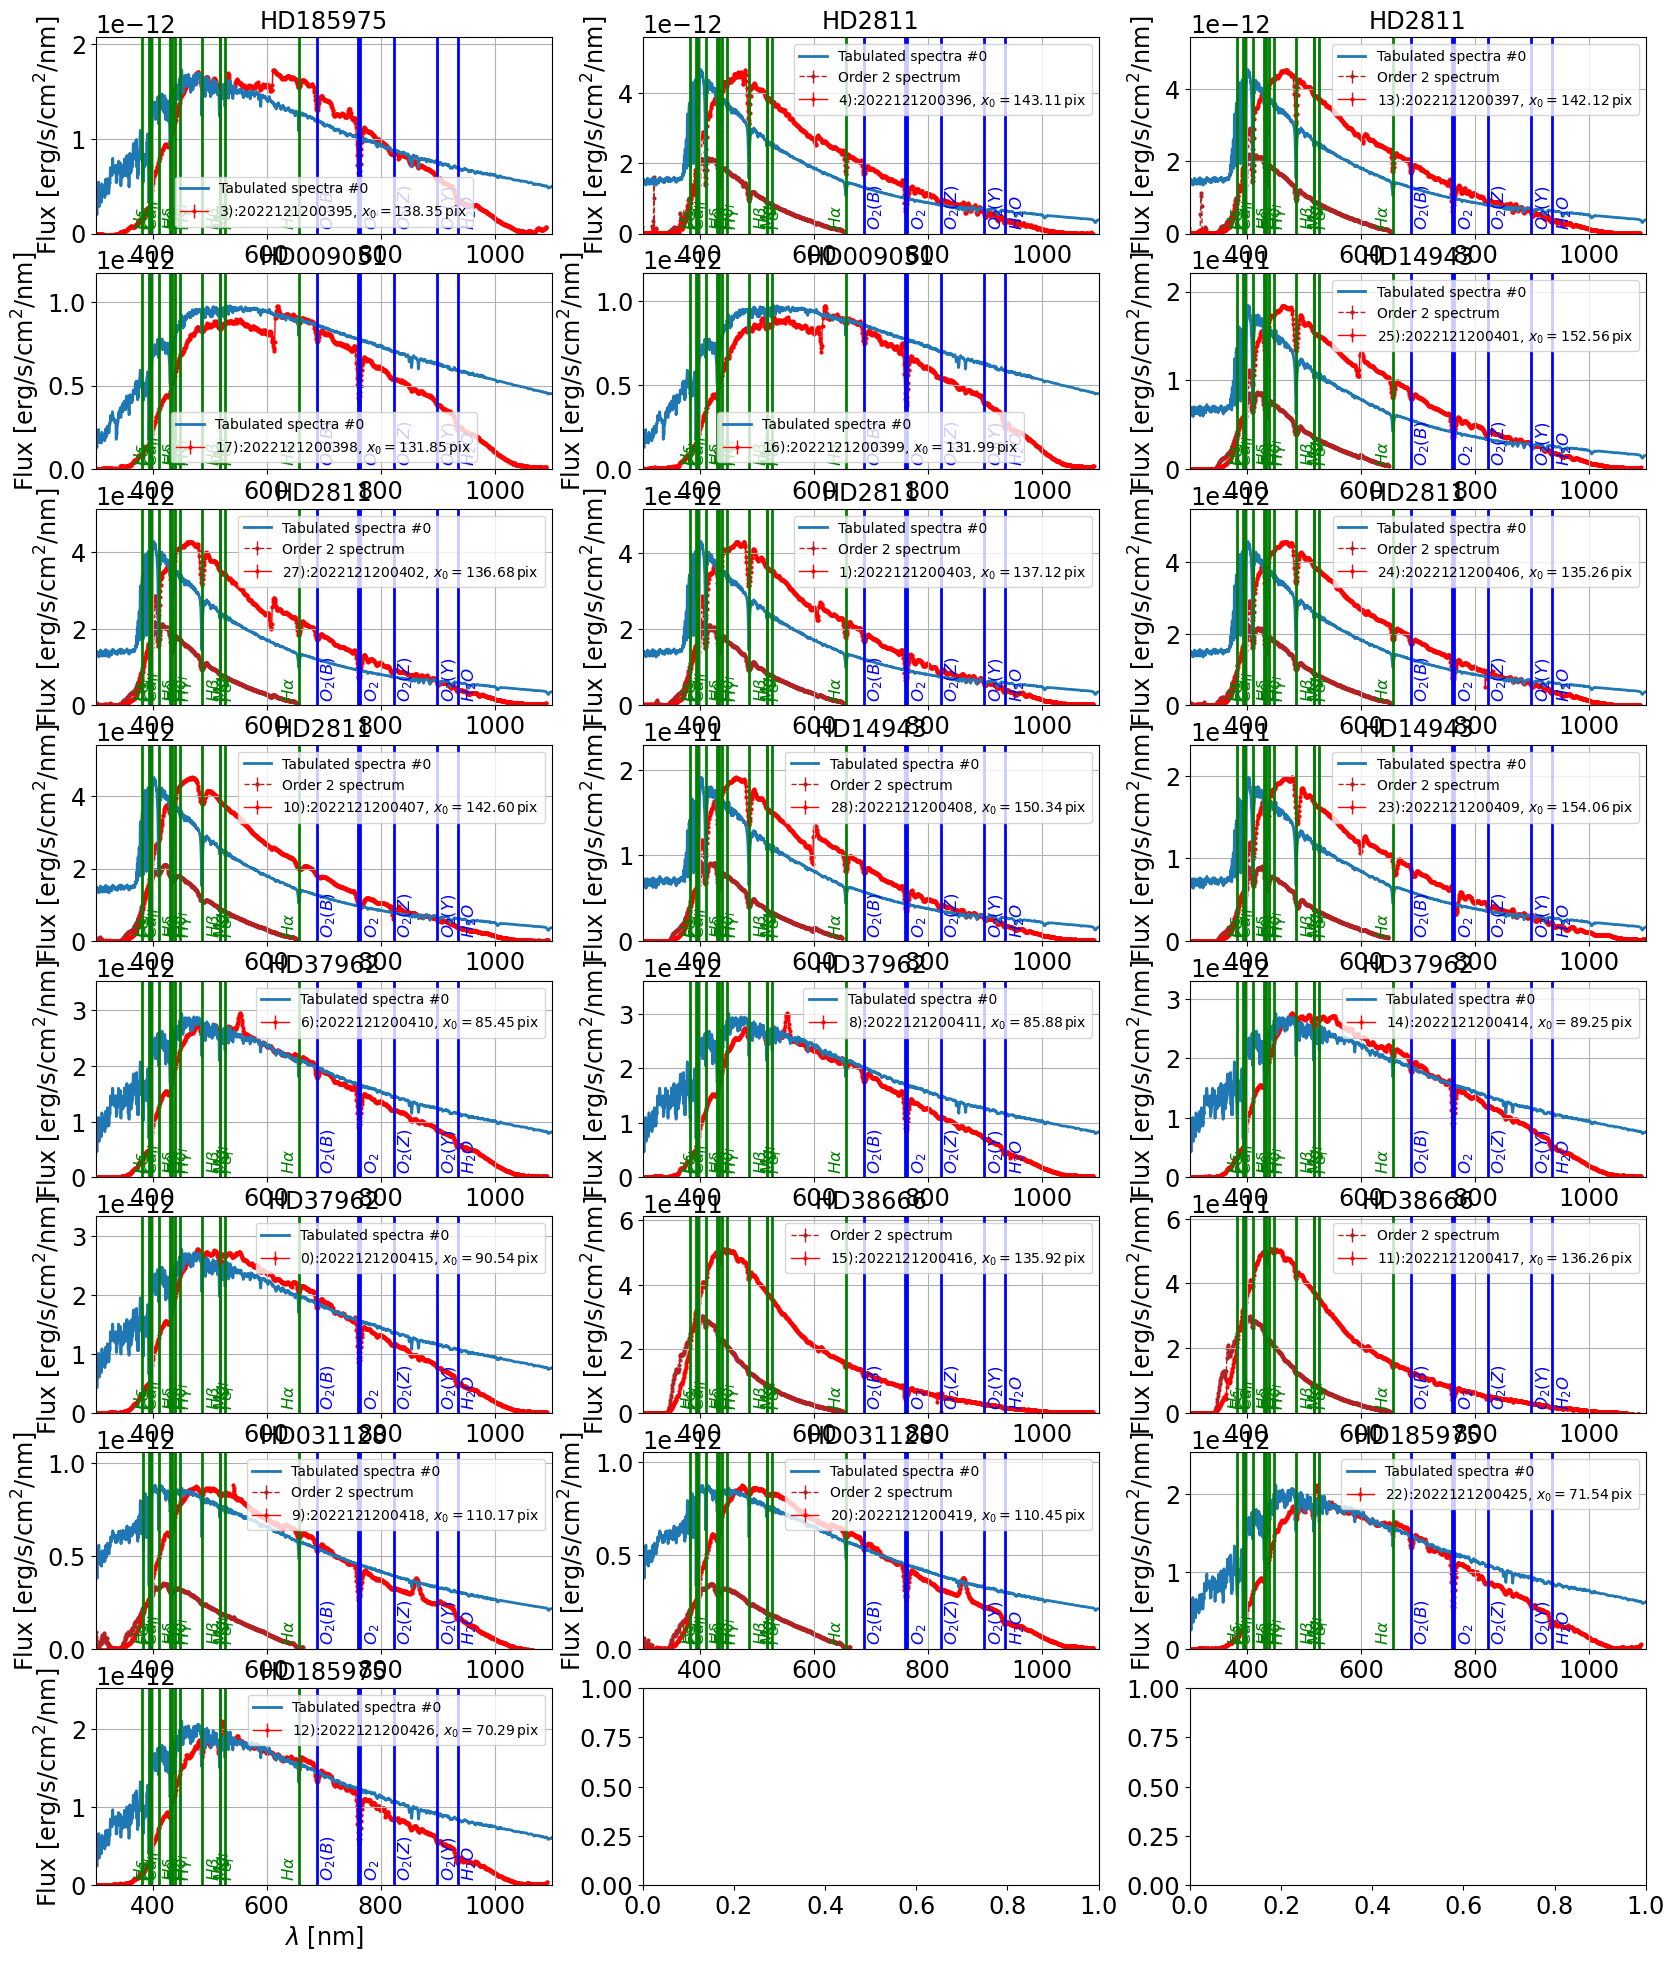

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

In [71]:
%matplotlib inline

ncols = 3
nrows = int(np.ceil(NN/ncols))


fig=plt.figure(figsize=(20,3*nrows))
axes = fig.subplots(nrows,ncols)
                            

infos = []
all_lambdas=[]
all_data=[]
all_data_err=[]



#for idx,ax in enumerate(axes.flat):
for idx in range(NN):
    if idx>=NN:
        break
        
    irow = idx//ncols
    icol = idx - irow*ncols
    

    ax = axes[irow,icol]
    
    # index in the list of selected sequences 
   
    the_seq = list_of_seq_sel_sorted[idx] 
    rank= selected_rank[the_seq]
    
    
    #s=spec.spectrum
    s=all_spec[rank]
    the_exposure = all_exposures[rank]
    label = str(rank) +"):" + str(the_exposure)
    
    
    airmass = s.airmass
    
    try:
        fig=plt.figure(figsize=(8,4))
       
        s.plot_spectrum(ax=ax,force_lines=True,label=label)

    
        all_lambdas.append(s.lambdas)
        all_data.append(s.data)
        all_data_err.append(s.err)
        
        suptitle = f"exp {the_exposure}, airmass {airmass:.2f}"
        #ax.set_title(suptitle,fontsize=15)
      
    
            
    except Exception as inst:
        print(" >>> Exception catched for "+ label )
        print(type(inst))    # the exception instance
        print(inst.args)     # arguments stored in .args

    
plt.tight_layout() 